In [1]:
%matplotlib inline

# PyTorch: Control Flow + Weight Sharing

PyTorch可以实现动态计算图。这里我们设计一个特殊的网络来看一看这种现象。在原来的two layers中间加入一个随机层，每次前向计算时，随机使用随机层{0, 1， 2， 3}次。

In [12]:
import random
import torch

class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)
        
    def forward(self, x):
        #每次forward都会构建一个计算图，因此我们可以任意地使用if or while
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred
        

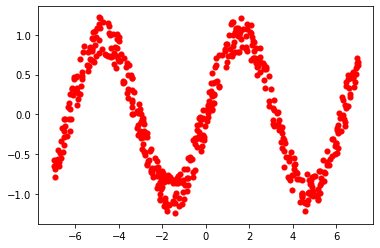

In [13]:
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# N是batch_size； D_in是输入的维度
# H是隐层的维度；D_out是输出的维度
N, D_in, H, D_out = 512, 1, 100, 1

#创建数据集，y通过sin函数计算并加上部分噪声
x = np.random.rand(N, D_in)
x = (x - 0.5) * 14
y = np.sin(x) + (np.random.rand(N, D_out) - 0.5) * 0.5
plt.scatter(x,y,color="red", linewidth=0.1)
x = torch.from_numpy(x).type(dtype).to(device)
y = torch.from_numpy(y).type(dtype).to(device)

In [14]:
model = DynamicNet(D_in, H, D_out).to(device)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

for epoch in range(50000):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    if epoch % 1000 == 0:
        print("epoch:",epoch, "loss:", loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 0 loss: 249.51248168945312
epoch: 1000 loss: 138.4288330078125
epoch: 2000 loss: 139.254638671875
epoch: 3000 loss: 75.8170166015625
epoch: 4000 loss: 48.19208526611328
epoch: 5000 loss: 28.278453826904297
epoch: 6000 loss: 106.90846252441406
epoch: 7000 loss: 14.374250411987305
epoch: 8000 loss: 12.677680015563965
epoch: 9000 loss: 16.86163330078125
epoch: 10000 loss: 21.7559814453125
epoch: 11000 loss: 17.594030380249023
epoch: 12000 loss: 10.691692352294922
epoch: 13000 loss: 10.124709129333496
epoch: 14000 loss: 10.194541931152344
epoch: 15000 loss: 10.048576354980469
epoch: 16000 loss: 10.050406455993652
epoch: 17000 loss: 11.403594017028809
epoch: 18000 loss: 9.803115844726562
epoch: 19000 loss: 10.982872009277344
epoch: 20000 loss: 9.996445655822754
epoch: 21000 loss: 9.773667335510254
epoch: 22000 loss: 16.276138305664062
epoch: 23000 loss: 35.628868103027344
epoch: 24000 loss: 10.361568450927734
epoch: 25000 loss: 13.030607223510742
epoch: 26000 loss: 11.859850883483887

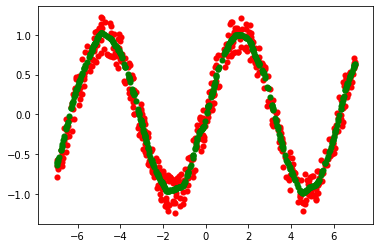

In [15]:
y_pred = model(x)
plt.scatter(x.detach().cpu().numpy(),y.detach().cpu().numpy(),color="red", linewidth=0.1)
plt.scatter(x.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), color='green', linewidth=0.1)